In [ ]:
!wget --no-check-certificate "https://gtvault-my.sharepoint.com/:x:/g/personal/rsalih3_gatech_edu/EWBQToQ7qt1ErgaoC_gC2fcBJEBIIH5A1t1zTyy1IU8GBQ?e=KWfnMz&download=1"

--2023-11-27 00:51:59--  https://gtvault-my.sharepoint.com/:x:/g/personal/rsalih3_gatech_edu/EWBQToQ7qt1ErgaoC_gC2fcBJEBIIH5A1t1zTyy1IU8GBQ?e=KWfnMz&download=1
Resolving gtvault-my.sharepoint.com (gtvault-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to gtvault-my.sharepoint.com (gtvault-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/rsalih3_gatech_edu/Documents/MGT%206203%20Project/MasterDataset_WithWeatherAndEvent.csv?ga=1 [following]
--2023-11-27 00:52:00--  https://gtvault-my.sharepoint.com/personal/rsalih3_gatech_edu/Documents/MGT%206203%20Project/MasterDataset_WithWeatherAndEvent.csv?ga=1
Reusing existing connection to gtvault-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 3223788015 (3.0G) [application/octet-stream]
Saving to: ‘EWBQToQ7qt1ErgaoC_gC2fcBJEBIIH5A1t1zTyy1IU8GBQ?e=KWfnMz&download=1’

EWBQToQ7qt1ErgaoC_g 100%[================

import data

In [ ]:
import pandas as pd

file_path = "data.csv"

data = pd.read_csv(file_path)

<ipython-input-2-591391ae8eba>:5: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


drop unwanted columns

In [ ]:
data = data.drop(data.columns[[0,1,2]], axis=1)
data = data.drop(["date", "time"], axis=1)

deal with missing values

In [ ]:
data['holiday'].fillna("Not a holiday", inplace=True)
data = data.dropna(how='any',axis=0)

deal with outliers

In [ ]:
cols = ["Duration"] #Numeric columns only
Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data[cols] < (Q1 - 1.5 * IQR)) |(data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
after_outlier = len(data)

confer appropriate datatypes

In [ ]:
data_types = pd.DataFrame({'Column Name': data.columns, 'Data Type': data.dtypes})

data_types

,Column Name,Data Type
Duration,Duration,int64
Start date,Start date,object
End date,End date,object
Start station number,Start station number,float64
Start station,Start station,object
End station number,End station number,float64
End station,End station,object
Member type,Member type,object
temperature_2m,temperature_2m,float64
relativehumidity_2m,relativehumidity_2m,int64


In [ ]:
data[['Start date', 'End date']] = data[['Start date', 'End date']].apply(pd.to_datetime)
data[['Start station', 'Start station number', 'End station','End station number', 'Member type', 'holiday']] = data[['Start station', 'Start station number', 'End station','End station number', 'Member type', 'holiday']].astype('category')
data[["Duration", "temperature_2m", "relativehumidity_2m", "precipitation", "windspeed_10m"]] = data[["Duration", "temperature_2m", "relativehumidity_2m", "precipitation", "windspeed_10m"]].astype('float')
data["isHoliday"] = data["isHoliday"].astype("boolean")

feature engineering

In [ ]:
data[["year", "month", "m_day", "hour"]] = data["Start date"].apply(lambda x: x.timetuple()[0:4]).tolist()
data["w_day"] = data["Start date"].apply(lambda x: x.weekday())

data["isWeekend"] = data["w_day"] > 4
data["isWeekend"] = data["isWeekend"].astype("boolean")

deal with miscellaneous discrepancies

In [ ]:
data["Member type"] = data["Member type"].str.lower()
data = data[data["Start date"].dt.year < 2020]
data = data[data["Duration"] >= 0]

GROUP BY data

In [ ]:
columns = ["holiday", "isHoliday", "year", "month", "m_day", "w_day"]
data_agg = data.groupby([data["Start date"].dt.date, "hour"]).agg(
    {
        "Duration": ["count", "mean"],
        "year": lambda x: x.value_counts().index[0],
        "month": lambda x: x.value_counts().index[0],
        "m_day": lambda x: x.value_counts().index[0],
        "w_day": lambda x: x.value_counts().index[0],
        "temperature_2m": "mean",
        "relativehumidity_2m": "mean",
        "precipitation": "mean",
        "windspeed_10m": "mean",
        "holiday": lambda x: x.value_counts().index[0],
        "isHoliday": lambda x: x.value_counts().index[0],
        "isWeekend": lambda x: x.value_counts().index[0]
    }
).reset_index()

In [ ]:
data_agg.columns = ['Start date', 'hour', 'count rides', 'Duration', 'year', 'month', 'm_day', 'w_day', 'temperature_2m', 'relativehumidity_2m', 'precipitation', 'windspeed_10m', 'holiday', 'isHoliday', 'isWeekend']

-----------------------------
EDA

rides per hour

<Axes: xlabel='hour', ylabel='count rides'>

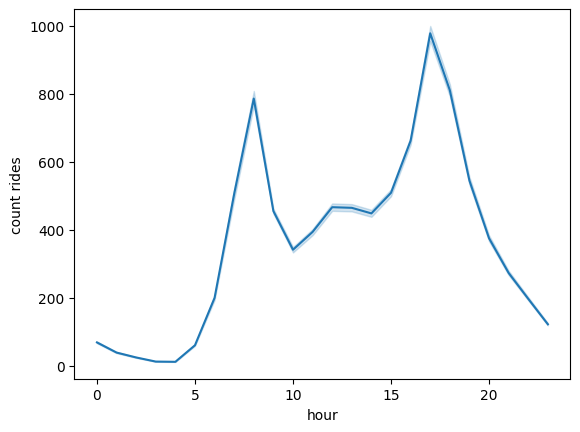

In [ ]:
import seaborn as sns
sns.lineplot(data=data_agg, x='hour', y='count rides')

<Axes: xlabel='hour', ylabel='count rides'>

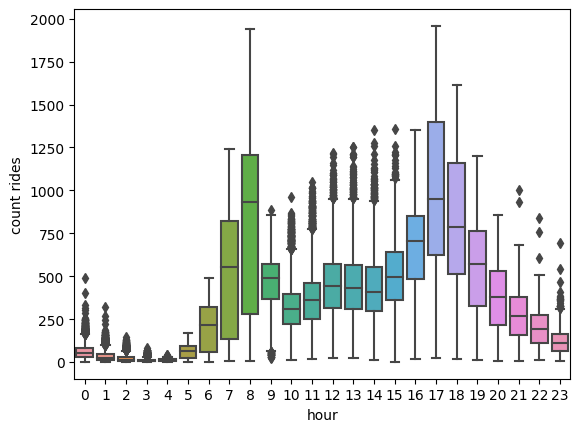

In [ ]:
sns.boxplot(data=data_agg, x='hour', y='count rides')

9-5
lack of outliers
presence of outliers in between confirming status quo
this signal pushes through amongst weekends and holdiays shows the most common use of the service

rides per day of week

<Axes: xlabel='w_day', ylabel='count rides'>

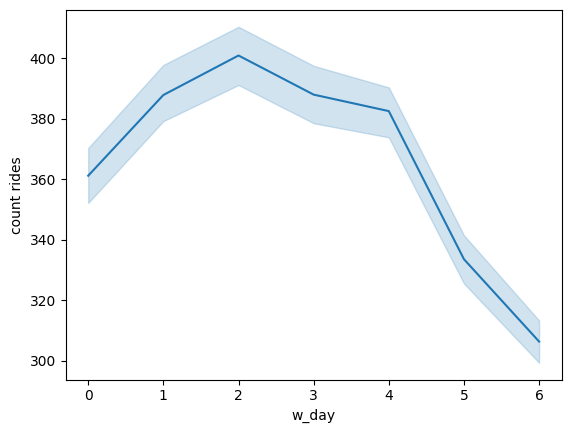

In [ ]:
sns.lineplot(data=data_agg, x='w_day', y='count rides')

Tremendous dropoff after Friday

<Axes: xlabel='w_day', ylabel='count rides'>

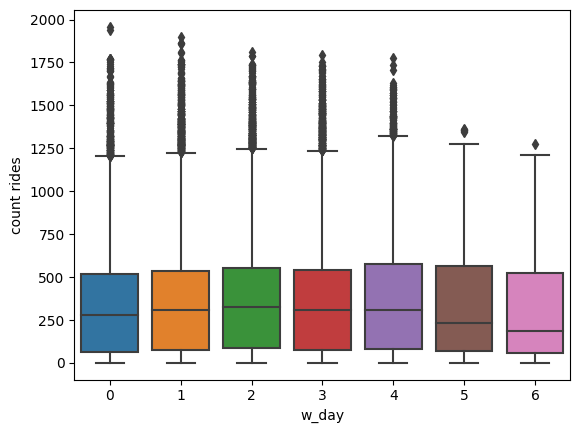

In [ ]:
import seaborn as sns
sns.boxplot(data=data_agg, x='w_day', y='count rides')

rides per day of month

<Axes: xlabel='m_day', ylabel='count rides'>

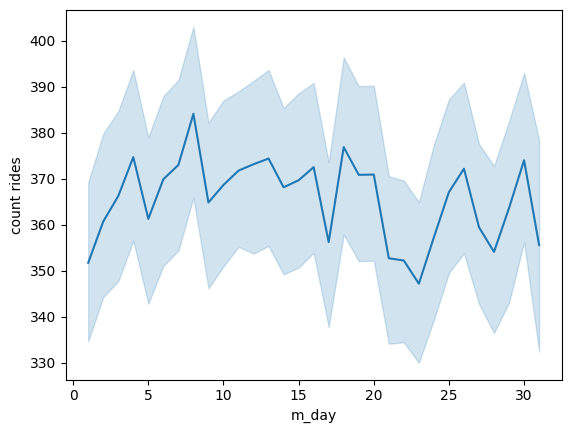

In [ ]:
sns.lineplot(data=data_agg, x='m_day', y='count rides')

<Axes: xlabel='m_day', ylabel='count rides'>

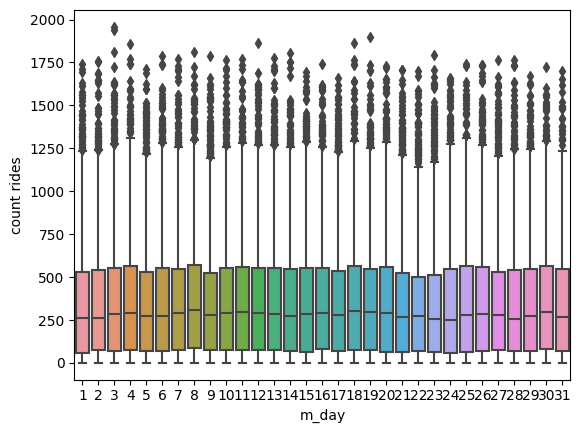

In [ ]:
import seaborn as sns
sns.boxplot(data=data_agg, x='m_day', y='count rides')

rides per month

<Axes: xlabel='month', ylabel='count rides'>

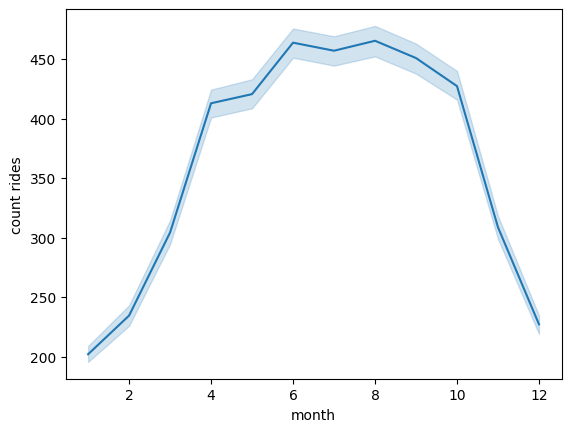

In [ ]:
sns.lineplot(data=data_agg, x='month', y='count rides')

<Axes: xlabel='month', ylabel='count rides'>

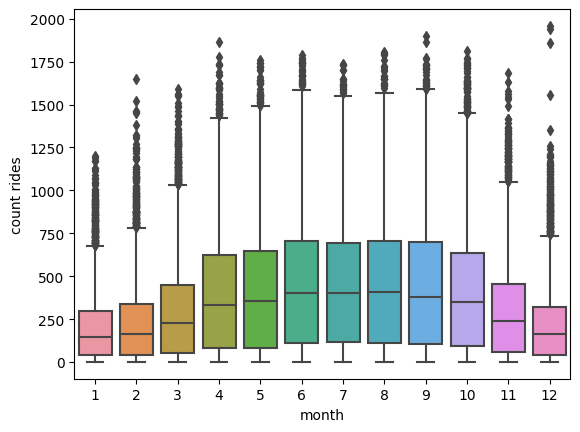

In [ ]:
import seaborn as sns
sns.boxplot(data=data_agg, x='month', y='count rides')

rides per year

<Axes: xlabel='year', ylabel='count rides'>

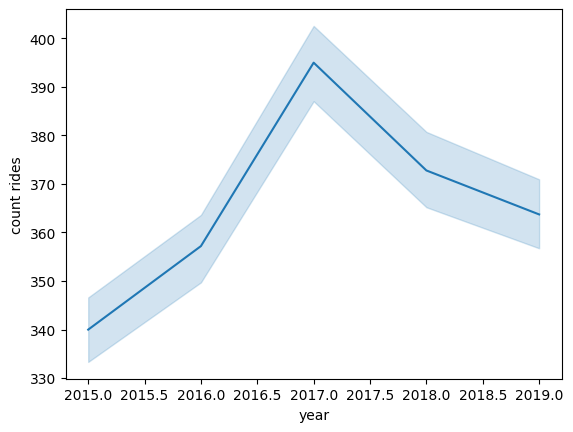

In [ ]:
sns.lineplot(data=data_agg, x='year', y='count rides')

<Axes: xlabel='year', ylabel='count rides'>

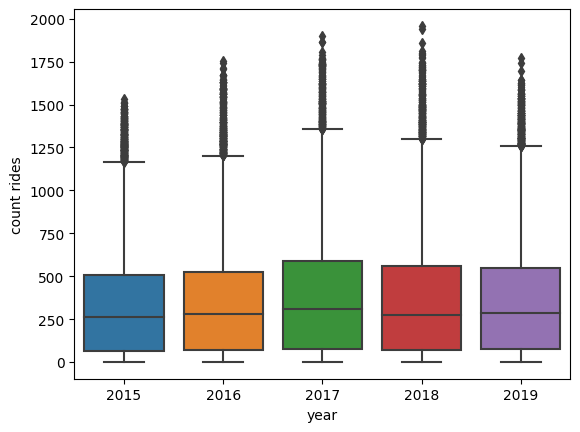

In [ ]:
import seaborn as sns
sns.boxplot(data=data_agg, x='year', y='count rides')

rides per temperature

In [ ]:
data_temp = data_agg[["temperature_2m", "count rides"]].groupby("temperature_2m").agg(
    {
        "count rides": "mean"
    }
).reset_index()

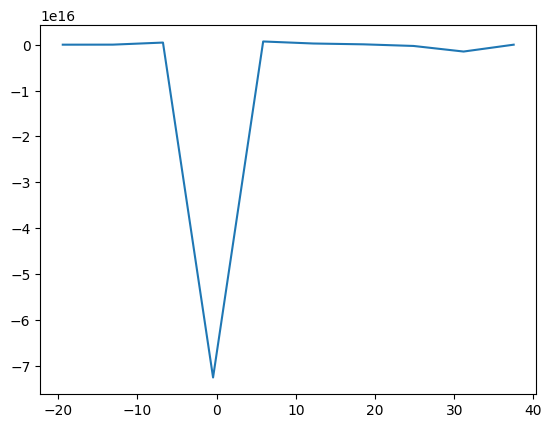

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
import numpy as np

x = data_temp["temperature_2m"]
y = data_temp["count rides"]

xnew = np.linspace(x.min(), x.max(), 10)

spl = make_interp_spline(x, y, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

<Axes: xlabel='temperature_2m', ylabel='count rides'>

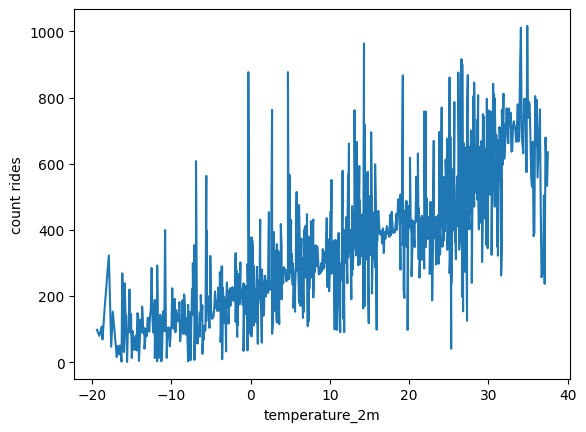

In [ ]:
sns.lineplot(data=data_temp, x='temperature_2m', y='count rides')

<Axes: xlabel='temperature_2m', ylabel='count rides'>

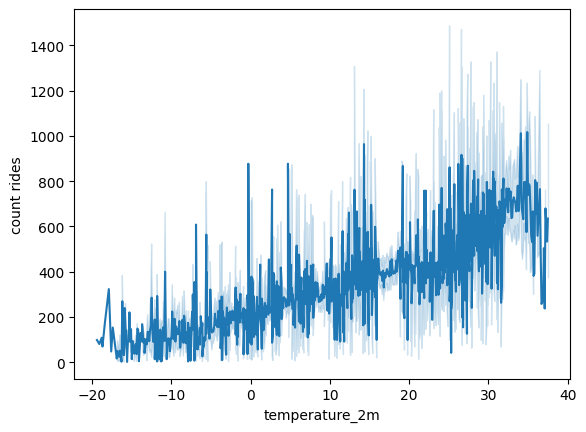

In [ ]:
sns.lineplot(data=data_agg, x='temperature_2m', y='count rides')

<Axes: xlabel='temperature_2m', ylabel='count rides'>

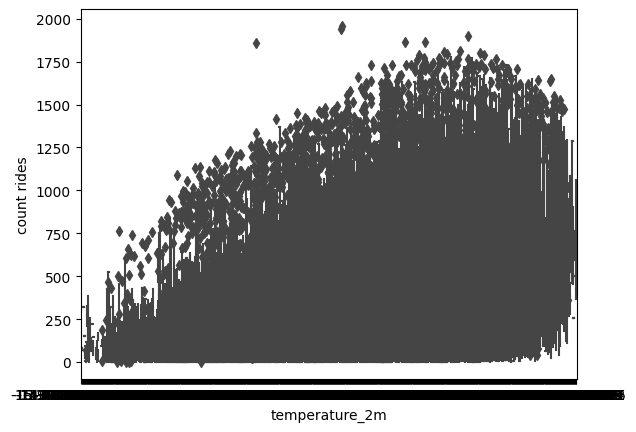

In [ ]:
import seaborn as sns
sns.boxplot(data=data_agg, x='temperature_2m', y='count rides')

rides per humidity

<Axes: xlabel='relativehumidity_2m', ylabel='count rides'>

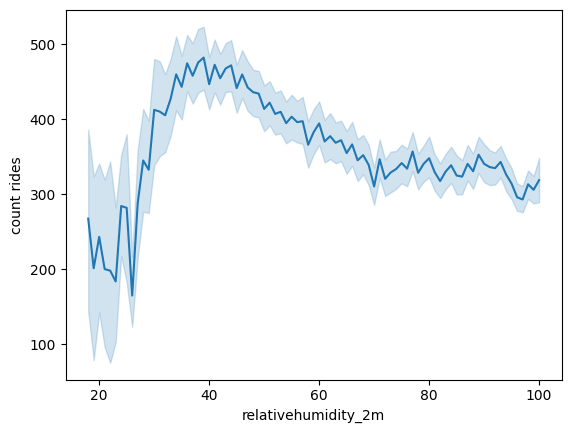

In [ ]:
sns.lineplot(data=data_agg, x='relativehumidity_2m', y='count rides')

<Axes: xlabel='relativehumidity_2m', ylabel='count rides'>

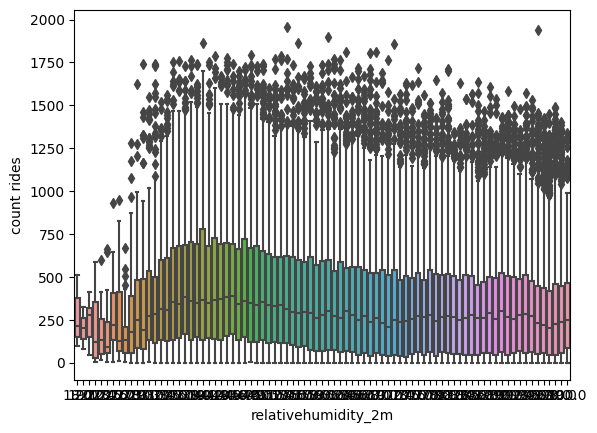

In [ ]:
import seaborn as sns
sns.boxplot(data=data_agg, x='relativehumidity_2m', y='count rides')

rides per precipitation

<Axes: xlabel='precipitation', ylabel='count rides'>

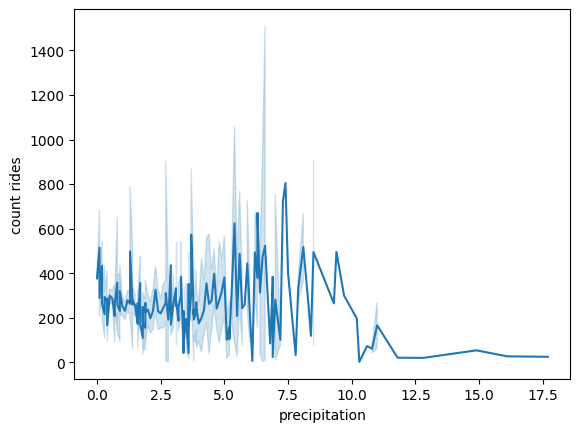

In [ ]:
sns.lineplot(data=data_agg, x='precipitation', y='count rides')

<Axes: xlabel='precipitation', ylabel='count rides'>

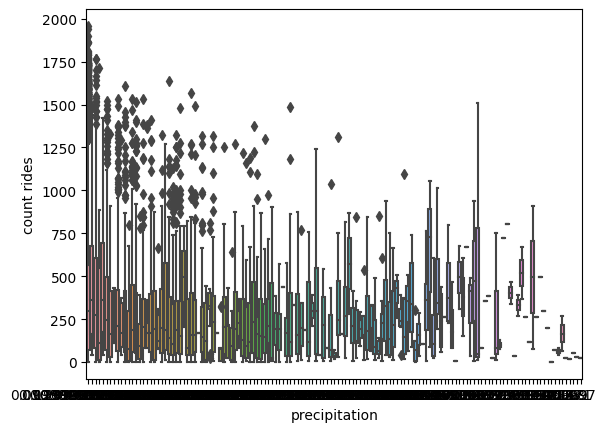

In [ ]:
import seaborn as sns
sns.boxplot(data=data_agg, x='precipitation', y='count rides')

rides per windspeed

<Axes: xlabel='windspeed_10m', ylabel='count rides'>

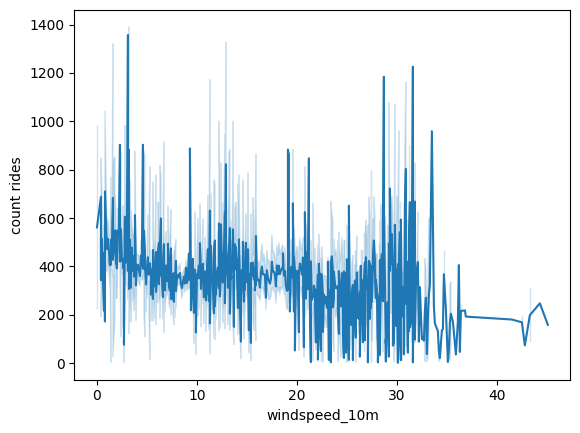

In [ ]:
sns.lineplot(data=data_agg, x='windspeed_10m', y='count rides')

<Axes: xlabel='windspeed_10m', ylabel='count rides'>

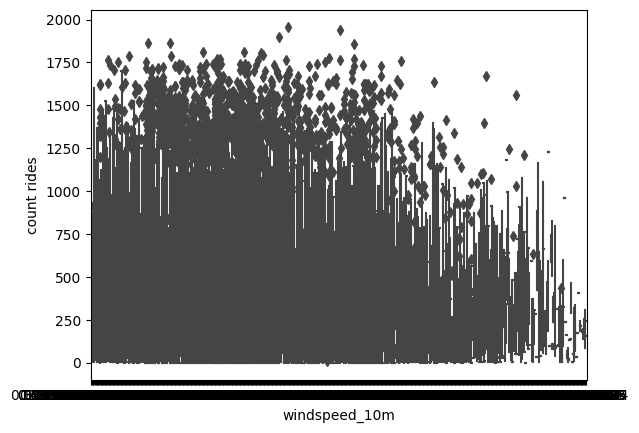

In [ ]:
import seaborn as sns
sns.boxplot(data=data_agg, x='windspeed_10m', y='count rides')

rides per holiday

<Axes: xlabel='isHoliday', ylabel='count rides'>

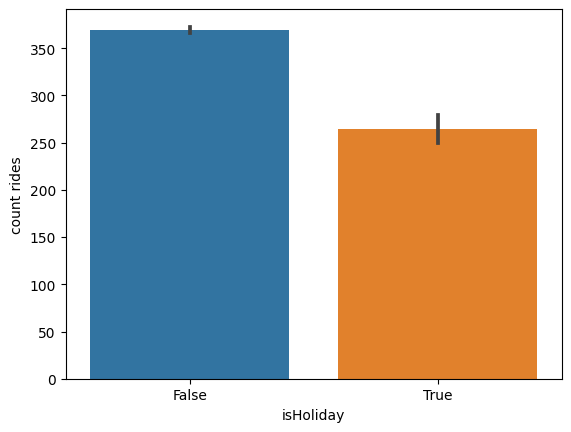

In [ ]:
sns.barplot(data=data_agg, x='isHoliday', y='count rides', estimator="mean")

<Axes: xlabel='isHoliday', ylabel='count rides'>

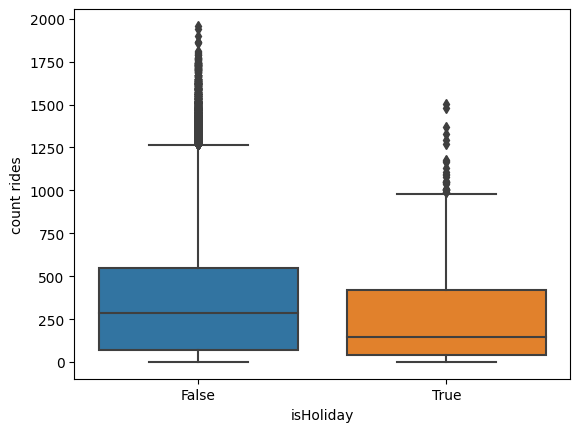

In [ ]:
import seaborn as sns
sns.boxplot(data=data_agg, x='isHoliday', y='count rides')

rides per weekend

<Axes: xlabel='isWeekend', ylabel='count rides'>

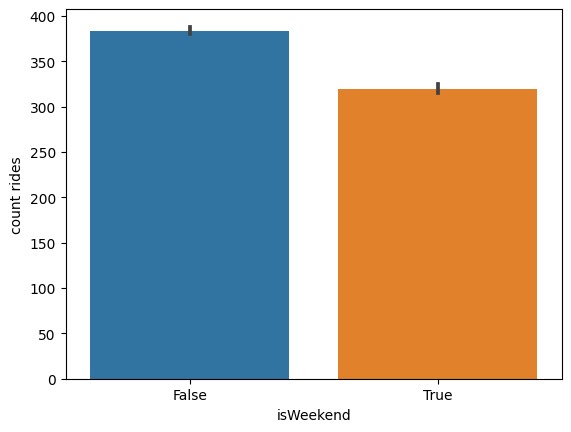

In [ ]:
sns.barplot(data=data_agg, x='isWeekend', y='count rides', estimator="mean")

<Axes: xlabel='isWeekend', ylabel='count rides'>

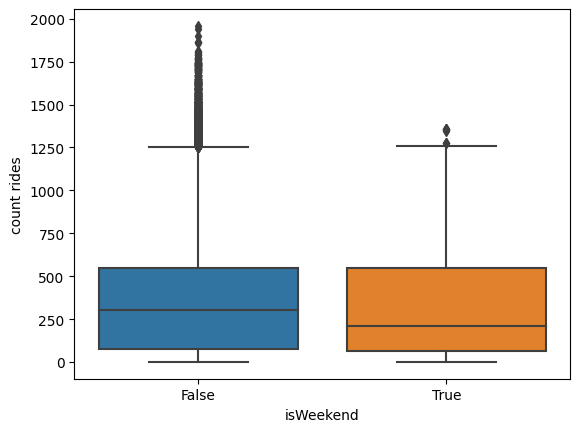

In [ ]:
import seaborn as sns
sns.boxplot(data=data_agg, x='isWeekend', y='count rides')